# Applying Sindy-SHRED to the C. elegan Dataset 

Data obtained from Global Brain Dynamics Embed the Motor Command Sequence of Caenorhabditis elegans. Cell, 163(3), 656–669. http://doi.org/10.1016/j.cell.2015.09.034

SHRED (SHallow REcurrent Decoder) models are a network architecture that merges a recurrent layer (LSTM) with a shallow decoder network (SDN) to reconstruct high-dimensional spatio-temporal fields from a trajectory of sensor measurements of the field. More formally, the SHRED architecture can be written as
$$ \mathcal {H} \left( \{ y_i \} _{i=t-k}^t \right) = \mathcal {F} \left( \mathcal {G} \left( \{ y_i \} _{i=t-k}^t \right) ; W_{RN}) ; W_{SD} \right)$$
where $\mathcal F$ is a feed forward network parameterized by weights $W_{SD}$, $\mathcal G$ is a LSTM network parameterized by weights $W_{RN}$, and $\{ y_i \} _{i=t-k}^t$ is a trajectory of sensor measurements of a high-dimensional spatio-temporal field $\{ x_i \} _{i=t-k}^t$.

SINDy-SHRED further extends the SHRED architecture by integrating **Sparse Identification of Nonlinear Dynamics (SINDy)** into the recurrent decoder framework. The key idea is to enforce a **parsimonious latent space representation**, where the dynamics of the latent variables are governed by a **sparse set of basis functions**.

More formally, SINDy-SHRED introduces an additional inductive bias:

$$\dot{z} = \Theta(z) \xi$$

where:

- $z = \mathcal{G} \left( \{ y_i \} _{i=t-k}^t \right)$ represents the **latent space variables** extracted by the LSTM encoder.
- $\Theta(z)$ is a **library of candidate nonlinear functions**.
- $\xi$ is a **sparse coefficient matrix** that determines the governing equations.

This combination enables **interpretable spatio-temporal modeling** by ensuring that the learned representations adhere to a **governing law**, making the method suitable for **data-driven discovery of dynamical systems** from high-dimensional, noisy observations.

In this notebook, we will walk through the application of **SINDy-SHRED** on the **teenage control MEG dataset**, demonstrating how the model can **learn a reduced-order latent representation** and **recover the governing equations** that describe brain dynamics.

In [2]:
# Clone the GitHub Repository
## git clone https://github.com/gaoliyao/sindy-shred.git
## pip install pysindy==1.7.5 numpy==1.23.5 scipy==1.13.1 scikit-learn==1.5.2

In [1]:
# Importing all dependencies 
import numpy as np
import numpy as np
import torch
import subprocess
import os
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import random
import mne
from scipy.signal import butter, filtfilt
from scipy.signal import welch
from scipy.interpolate import CubicSpline
from scipy.io import loadmat
from sklearn.linear_model import Ridge


In [2]:
#Importing packages
# Change into the directory
os.chdir("/home/amy/SHRED_neuro/sindy-shred") ## Change to where the repo was cloned

from processdata import load_data
from processdata import TimeSeriesDataset
import sindy
import pysindy as ps
from pysindy.differentiation import FiniteDifference

os.environ["CUDA_VISIBLE_DEVICES"]="0"


# Data Format
- 5 worms
- 18 mins at roughly 2.85 samples per second --> ~3000 samples per trial
- 107 - 131 neurons

*Worm One, No Stim*

In [9]:
!ls

neuroenv  sindy-shred  worms


In [3]:
# Loading the Dataset
# os.chdir("../")
os.chdir("../")

data_path = 'worms/worm_data/WT_Stim.mat'
data = loadmat(data_path)
print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'AVA_HisCl', 'WT_NoStim', 'WT_Stim'])


In [4]:
# Working with the no stim condition -- WORM ONE
no_stim = data['WT_NoStim']
neuron_data = no_stim[0][0][0] #3137 timepoints, 109 neurons 

time = no_stim[0][0][4]
dt = time[1][0] - time[0][0]

m = neuron_data.shape[0] # number of timepoints
n = neuron_data.shape[1] #number of neurons 

neuron_data_cor = no_stim[0][0][1]

neuron_name = []
for i in range((n-1)):
    neuron_name.append(no_stim[0][0][3][0][i][0])

sr = no_stim[0][0][6]
# Movement Classifications;  
# ‘FWD’ forward crawling ‘SLOW’ forward slowing ‘DT’ dorsal post reversal turn ‘VT’ ventral post reversal turn 
# ‘REV1’ reverse crawling ‘REV2’ reverse crawling ‘REVSUS’ sustained reverse crawling ‘NOSTATE’ - ambiguous
FWD = no_stim[0][0][7][0][0][0]
SLOW = no_stim[0][0][7][0][0][1]
DT = no_stim[0][0][7][0][0][2]
VT = no_stim[0][0][7][0][0][3]
REV1 = no_stim[0][0][7][0][0][4]
REV2 = no_stim[0][0][7][0][0][5]
REVSUS = no_stim[0][0][7][0][0][6]
NOSTATE = no_stim[0][0][7][0][0][7]

print(m,n)
print(time[-1])
print(sr)


3137 109
[1079.65572203]
[[2.90462963]]


In [5]:
print(neuron_data_cor)
print(neuron_data_cor[1,0])
load_X = neuron_data_cor

[[0.1971036  0.2772512  0.15407247 ... 0.46837034 0.25607834 0.3582931 ]
 [0.19316978 0.27975053 0.16162942 ... 0.4435926  0.27620445 0.36292656]
 [0.20246483 0.28147009 0.147317   ... 0.4720659  0.23780916 0.37709276]
 ...
 [0.08095081 0.15935624 0.05726877 ... 0.25223605 0.12992515 0.24421274]
 [0.08161957 0.12314727 0.09515152 ... 0.24836015 0.1103177  0.22273175]
 [0.0622557  0.16723433 0.074167   ... 0.22582504 0.10068002 0.22036835]]
0.19316977771053434


Randomly select n number of neurons and prepare the train, test, and validation sets. sklearn's MinMaxScaler is used to preprocess the data for training and we generate input/output pairs for the training, validation, and test sets.

Text(0, 0.5, 'Neurons')

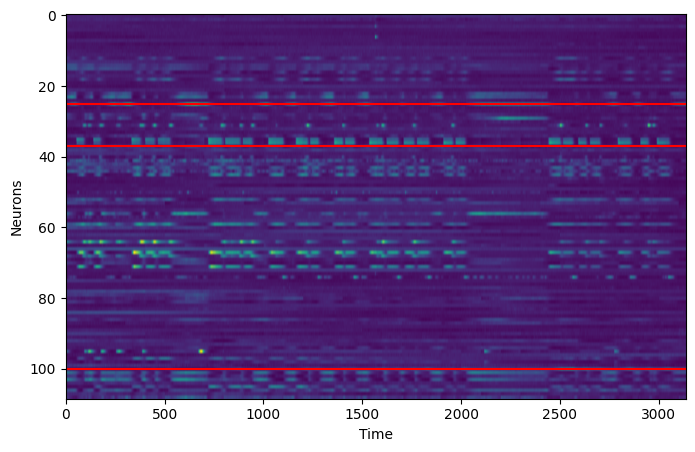

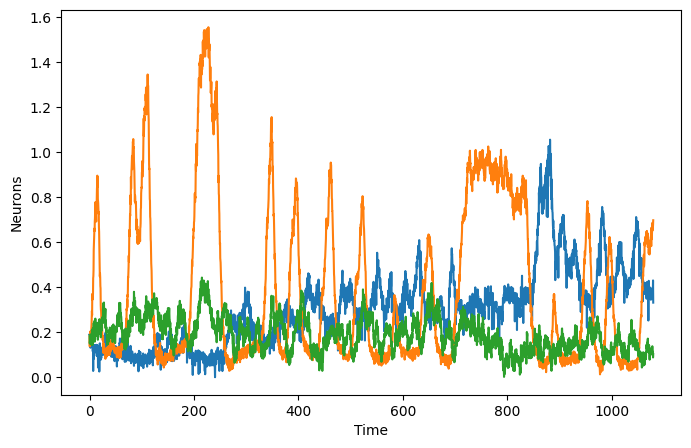

In [8]:
num_neurons = 3 
lags = 100

# Randomly select the neurons to train the SHRED model on
# neuron_locations = np.random.choice(n, size= num_neurons, replace=False) 
neuron_locations = np.array([100, 25, 37])

plt.figure(figsize = (8,5))
plt.imshow(load_X.T, aspect = 'auto')
plt.xlabel('Time')
plt.ylabel('Neurons')

for i in range(neuron_locations.shape[0]):
  plt.axhline(neuron_locations[i], color = 'red')


plt.figure(figsize = (8,5))
plt.plot(time, load_X[:,neuron_locations])
plt.xlabel('Time')
plt.ylabel('Neurons')

In [14]:
print(neuron_locations)

[99  9 25]


Text(0, 0.5, 'Neurons')

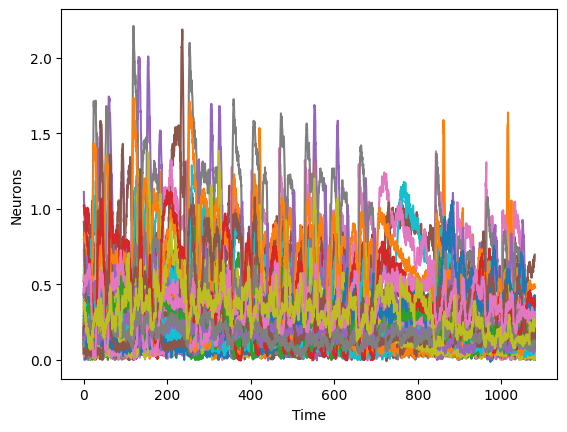

In [9]:
plt.plot(time, load_X)
plt.xlabel('Time')
plt.ylabel('Neurons')



In [ ]:
### Get data- Segment One
test_recons_one = []
for k in range(10):
    data  = np.load(f"/home/amy/SHRED_neuro/worms/data_output/exp_one/exp_one_test_recons0_{k}.npy")
    test_recons_one.append(data)

test_gt_one = []
for k in range(10):
    data  = np.load(f"/home/amy/SHRED_neuro/worms/data_output/exp_one/exp_one_test_gt0_{k}.npy")
    test_gt_one.append(data)

train_recons_one = []
for k in range(10):
    data  = np.load(f"/home/amy/SHRED_neuro/worms/data_output/exp_one/exp_one_train_recons0_{k}.npy")
    train_recons_one.append(data)

train_gt_one = []
for k in range(10):
    data  = np.load(f"/home/amy/SHRED_neuro/worms/data_output/exp_one/exp_one_train_gt0_{k}.npy")
    train_gt_one.append(data)

mse_one = []
for k in range(10):
    data  = np.load(f"/home/amy/SHRED_neuro/worms/data_output/exp_one/exp_one_mse0_{k}.npy")
    mse_one.append(data)


In [26]:
sum = np.zeros((np.array(test_gt_one).shape[1], np.array(test_gt_one).shape[2]))
print(sum.shape)
for k in range(np.array(test_gt_one).shape[0]):
    sum = sum + test_gt_one[k]
test_average_gt = sum/k


sum = np.zeros((np.array(test_recons_one).shape[1], np.array(test_recons_one).shape[2]))
print(sum.shape)
for k in range(np.array(test_recons_one).shape[0]):
    sum = sum + test_recons_one[k]
test_average_recons = sum/k

(75, 109)
(75, 109)


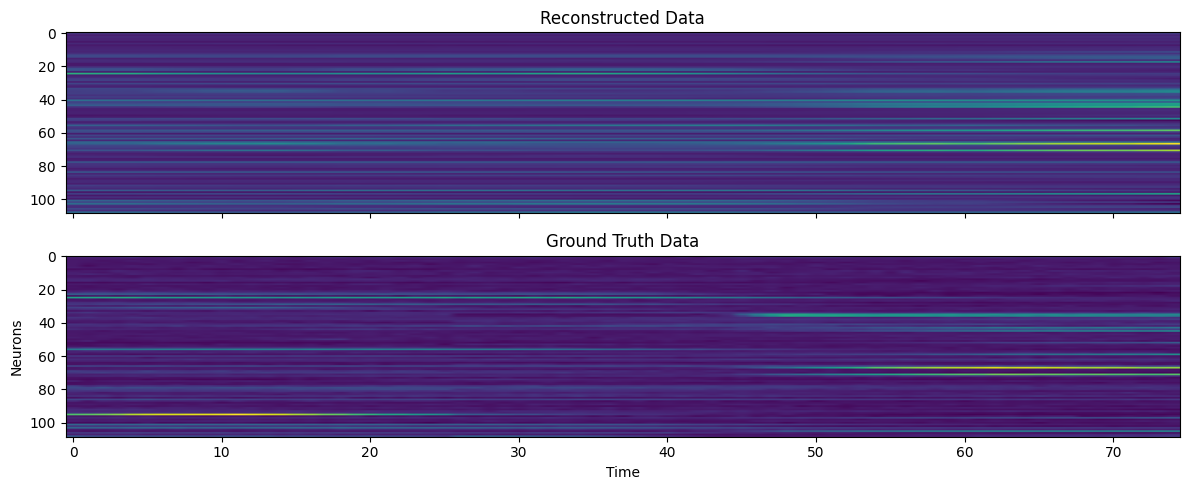

In [27]:
### Reconstructed and ground truth Carpet Plot
fig, axes = plt.subplots(2, figsize=(12, 5), sharex=True, sharey=True)
# Plot the reconstructed data
axes[0].imshow(test_average_recons.T, aspect='auto')
axes[0].set_title("Reconstructed Data")
# Plot the ground truth data
axes[1].imshow(test_average_gt.T, aspect='auto')
axes[1].set_title("Ground Truth Data")
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Neurons')


plt.tight_layout()
plt.show()



# ### Reconstructed and ground truth Activity Traces - selected neurons
# fig, axes = plt.subplots(1,num_neurons, figsize=(12, 3), sharex=True, sharey=True)
# for i in range(num_neurons):
#     axes[i].plot(test_recons[:, neuron_locations[i]], label = "Reconstructed Data", color = 'red')
#     axes[i].plot(test_ground_truth[:, neuron_locations[i]], label = 'Ground Truth Data', color = 'grey')
#     axes[1].set_title('Neurons Selected')
# plt.legend()
# plt.tight_layout()
# plt.show()


# ### Reconstructed and ground truth Activity Traces - random neurons
# neuron_loc_graph = np.random.choice(n, size= 5, replace=False) 
# fig, axes = plt.subplots(1, 5, figsize=(12, 3), sharex=True, sharey=True)
# for i in range(5):
#     axes[i].plot(test_recons[:, neuron_loc_graph[i]], label = "Reconstructed Data", color = 'red')
#     axes[i].plot(test_ground_truth[:, neuron_loc_graph[i]], label = 'Ground Truth Data', color ='grey')
#     axes[2].set_title('Neurons Randomly Selected')
# plt.legend()
# plt.tight_layout()
# plt.show()

In [10]:
test_val_size = 600
train_indices = np.arange(0, m - lags - test_val_size)
mask = np.ones(m - lags)
mask[train_indices] = 0
valid_test_indices = np.arange(0, m - lags)[np.where(mask!=0)[0]]
valid_indices = valid_test_indices[:int(test_val_size/2)]
test_indices = valid_test_indices[int(test_val_size/2):test_val_size]

In [11]:
sc = MinMaxScaler()
sc = sc.fit(load_X[train_indices])
transformed_X = sc.transform(load_X)

### Generate input sequences to a SHRED model
all_data_in = np.zeros((m - lags, lags, num_neurons))
for i in range(len(all_data_in)):
    all_data_in[i] = transformed_X[i:i+lags, neuron_locations]

### Generate training validation and test datasets both for reconstruction of states and forecasting sensors
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

### -1 to have output be at the same time as final sensor measurements
train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


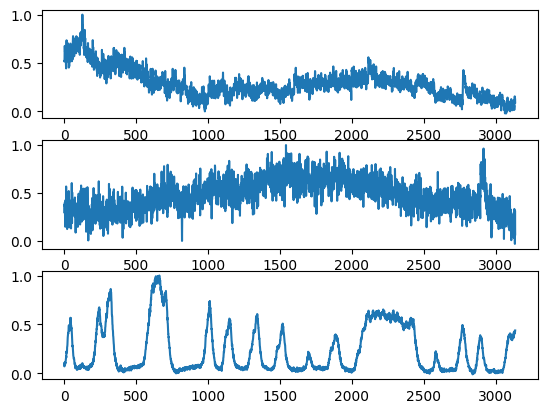

In [11]:
# Plotting the normalized activity recorded from the neurons selected

sub_index_X = transformed_X[:,neuron_locations]
fig, ax = plt.subplots(num_neurons)

for i in range(num_neurons):
    ax[i].plot(sub_index_X[:,i])


Set up Sindy Library Coefficients

In [12]:
latent_dim = 4
poly_order = 2
include_sine = True
library_dim = sindy.library_size(latent_dim, poly_order, include_sine, True)

Run the SHRED model and evaluate using MSE

In [17]:
os.chdir("/home/amy/SHRED_neuro/sindy-shred")
import sindy_shred
shred = sindy_shred.SINDy_SHRED(num_neurons, n, hidden_size=latent_dim, hidden_layers=2, l1=350, l2=400, dropout=0.1,
                                 library_dim=library_dim, poly_order=poly_order,
                                include_sine=include_sine, dt=dt, layer_norm=False).to(device)

validation_errors = sindy_shred.fit(shred, train_dataset, valid_dataset, batch_size=128, num_epochs=100,
                                    lr=1e-3, verbose=True, threshold=0.25, patience=5, sindy_regularization=10.0,
                                    optimizer="AdamW", thres_epoch=100)

1 : tensor(0.0590, device='cuda:0', grad_fn=<AddBackward0>)
2 : tensor(0.0451, device='cuda:0', grad_fn=<AddBackward0>)
3 : tensor(0.0429, device='cuda:0', grad_fn=<AddBackward0>)
4 : tensor(0.0420, device='cuda:0', grad_fn=<AddBackward0>)
5 : tensor(0.0401, device='cuda:0', grad_fn=<AddBackward0>)
6 : tensor(0.0407, device='cuda:0', grad_fn=<AddBackward0>)
7 : tensor(0.0384, device='cuda:0', grad_fn=<AddBackward0>)
8 : tensor(0.0368, device='cuda:0', grad_fn=<AddBackward0>)
9 : tensor(0.0366, device='cuda:0', grad_fn=<AddBackward0>)
10 : tensor(0.0374, device='cuda:0', grad_fn=<AddBackward0>)
11 : tensor(0.0360, device='cuda:0', grad_fn=<AddBackward0>)
12 : tensor(0.0364, device='cuda:0', grad_fn=<AddBackward0>)
13 : tensor(0.0364, device='cuda:0', grad_fn=<AddBackward0>)
14 : tensor(0.0374, device='cuda:0', grad_fn=<AddBackward0>)
15 : tensor(0.0357, device='cuda:0', grad_fn=<AddBackward0>)
16 : tensor(0.0360, device='cuda:0', grad_fn=<AddBackward0>)
17 : tensor(0.0353, device='cuda:

MSE 0.6101812


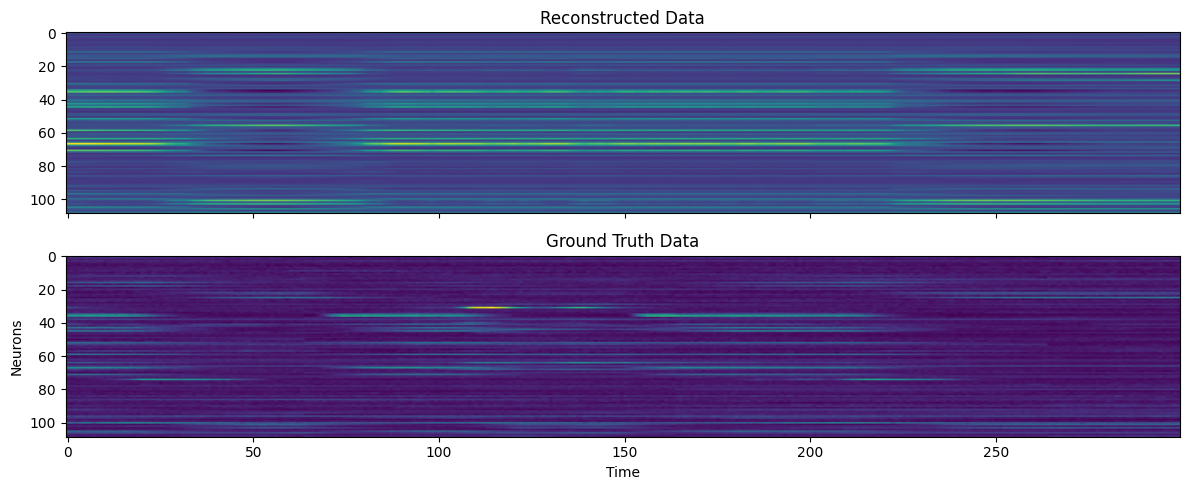

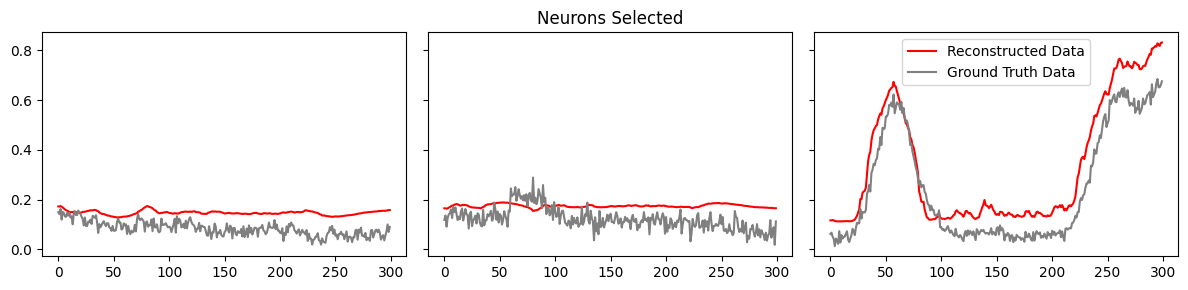

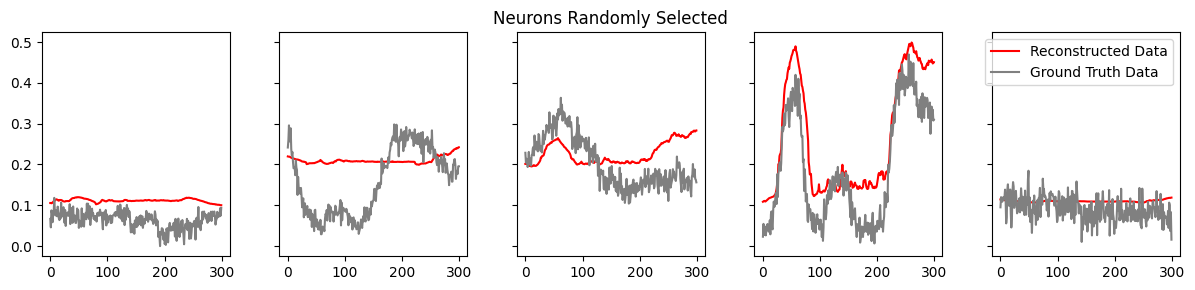

In [18]:
# Rate of sparsity
torch.mean(shred.e_sindy.coefficient_mask*1.0)

#Mean Squared Error
test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
mse = np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth)
print('MSE', mse)


### Reconstructed and ground truth Carpet Plot
fig, axes = plt.subplots(2, figsize=(12, 5), sharex=True, sharey=True)
# Plot the reconstructed data
axes[0].imshow(test_recons.T, aspect='auto')
axes[0].set_title("Reconstructed Data")
# Plot the ground truth data
axes[1].imshow(test_ground_truth.T, aspect='auto')
axes[1].set_title("Ground Truth Data")
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Neurons')


plt.tight_layout()
plt.show()



### Reconstructed and ground truth Activity Traces - selected neurons
fig, axes = plt.subplots(1,num_neurons, figsize=(12, 3), sharex=True, sharey=True)
for i in range(num_neurons):
    axes[i].plot(test_recons[:, neuron_locations[i]], label = "Reconstructed Data", color = 'red')
    axes[i].plot(test_ground_truth[:, neuron_locations[i]], label = 'Ground Truth Data', color = 'grey')
    axes[1].set_title('Neurons Selected')
plt.legend()
plt.tight_layout()
plt.show()


### Reconstructed and ground truth Activity Traces - random neurons
neuron_loc_graph = np.random.choice(n, size= 5, replace=False) 
fig, axes = plt.subplots(1, 5, figsize=(12, 3), sharex=True, sharey=True)
for i in range(5):
    axes[i].plot(test_recons[:, neuron_loc_graph[i]], label = "Reconstructed Data", color = 'red')
    axes[i].plot(test_ground_truth[:, neuron_loc_graph[i]], label = 'Ground Truth Data', color ='grey')
    axes[2].set_title('Neurons Randomly Selected')
plt.legend()
plt.tight_layout()
plt.show()

MSE 0.36622638


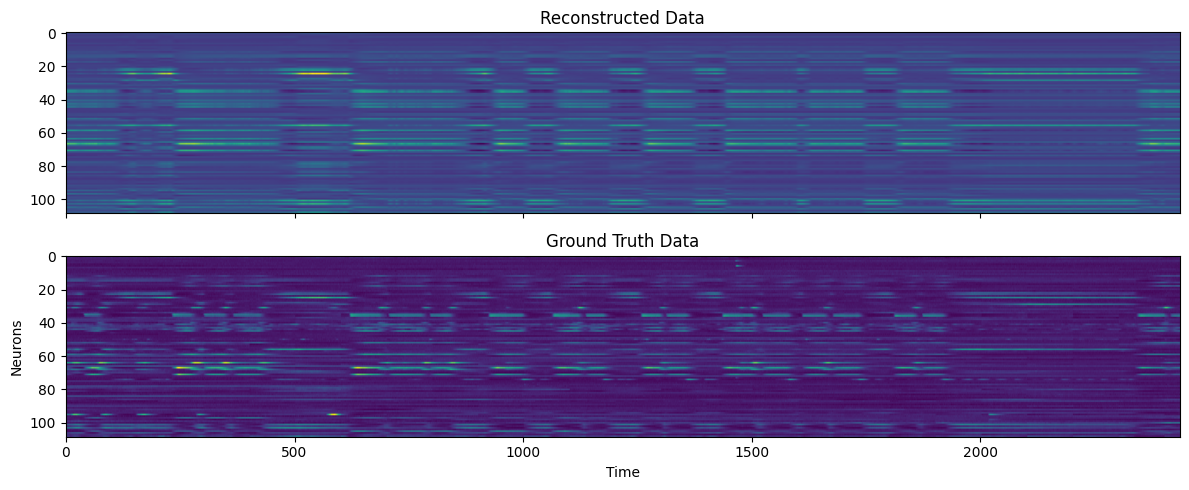

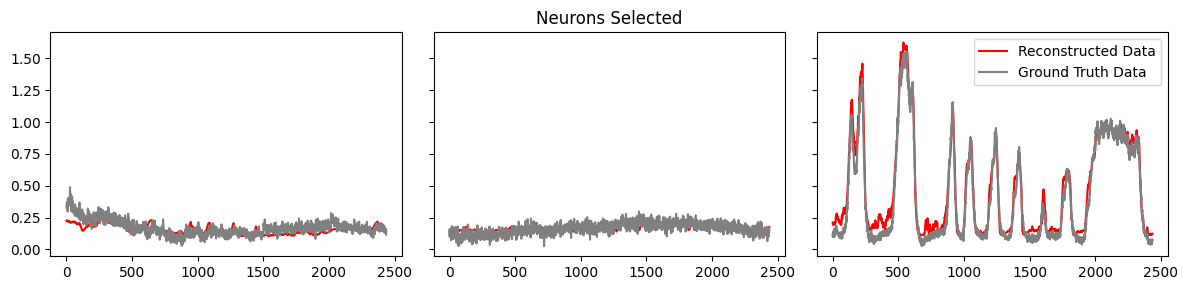

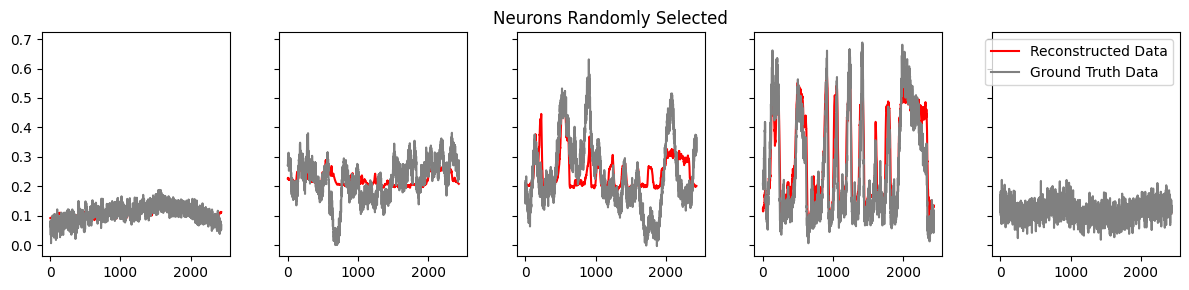

In [20]:
### Train Data Reconstruction

train_recons = sc.inverse_transform(shred(train_dataset.X).detach().cpu().numpy())
train_ground_truth = sc.inverse_transform(train_dataset.Y.detach().cpu().numpy())
mse = np.linalg.norm(train_recons - train_ground_truth) / np.linalg.norm(train_ground_truth)
print('MSE', mse)


### Reconstructed and ground truth Carpet Plot
fig, axes = plt.subplots(2, figsize=(12, 5), sharex=True, sharey=True)
# Plot the reconstructed data
axes[0].imshow(train_recons.T, aspect='auto')
axes[0].set_title("Reconstructed Data")
# Plot the ground truth data
axes[1].imshow(train_ground_truth.T, aspect='auto')
axes[1].set_title("Ground Truth Data")
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Neurons')


plt.tight_layout()
plt.show()



### Reconstructed and ground truth Activity Traces - selected neurons
fig, axes = plt.subplots(1,num_neurons, figsize=(12, 3), sharex=True, sharey=True)
for i in range(num_neurons):
    axes[i].plot(train_recons[:, neuron_locations[i]], label = "Reconstructed Data", color = 'red')
    axes[i].plot(train_ground_truth[:, neuron_locations[i]], label = 'Ground Truth Data', color = 'grey')
    axes[1].set_title('Neurons Selected')
plt.legend()
plt.tight_layout()
plt.show()


### Reconstructed and ground truth Activity Traces - random neurons
# neuron_loc_graph = np.random.choice(n, size= 5, replace=False) 
fig, axes = plt.subplots(1, 5, figsize=(12, 3), sharex=True, sharey=True)
for i in range(5):
    axes[i].plot(train_recons[:, neuron_loc_graph[i]], label = "Reconstructed Data", color = 'red')
    axes[i].plot(train_ground_truth[:, neuron_loc_graph[i]], label = 'Ground Truth Data', color ='grey')
    axes[2].set_title('Neurons Randomly Selected')
plt.legend()
plt.tight_layout()
plt.show()

Visualizing the Latent Space

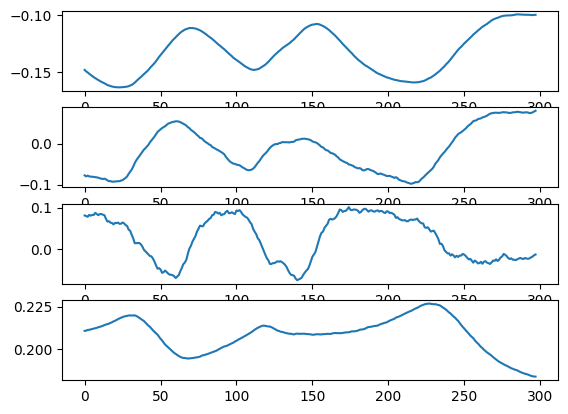

In [61]:
# plotting the latent space (first X dims)
gru_outs, sindy_outs = shred.gru_outputs(test_dataset.X, sindy=True)
differentiation_method = FiniteDifference()

latent_vis = latent_dim
fig, ax = plt.subplots(latent_vis)
for i in range(latent_vis):
    ax[i].plot(gru_outs[1:,0,i].detach().cpu().numpy())

### Model discovery with SINDy

The following code block extracts latent states using a GRU model. Each of the first three dimensions is normalized and re-scaled to [-1,1]. A SINDy model is then set up with a polynomial library. This SINDy model is fitted to the data and later used to simulate the dynamics for comparison with the original GRU latent trajectories.

The hyperparameters for the SINDy model are set as follows:
- **Differentiation Method:** Finite difference is used to compute numerical derivatives. When the latent states trajectories are noisy, one should consider to use ps.differentiation.SmoothedFiniteDifference().
- **Optimizer Sequantially thresholded least-squares: STLSQ:**  
  - *Threshold:* 0.8, which controls the sparsity level by eliminating coefficients below this value.
  - *Alpha:* 0.05, L2 regularization.
- **Optimizer Mixed-interger optimization: MIOSR:**  
  - *group_sparsity:* how many termseach equations should include.
- **Feature Library:** Here we only include polynomial features up to degree 1, ensuring only linear terms are considered in the model. Practically this could set up to degree 3 which will include more nonlinear terms.

For model selection, a simple baseline standard is to visually examine how the long-term extrapolation behaves. We can pick the model that fits the data well. It is also possible to include metrics (like the MSE) to quantitatively measure these quantities.

In [62]:
gru_outs_train, _ = shred.gru_outputs(train_dataset.X, sindy=True)
gru_outs_train = gru_outs_train[:,0,:]
gru_outs_val, _ = shred.gru_outputs(valid_dataset.X, sindy=True)
gru_outs_val = gru_outs_val[:,0,:]
gru_outs_test, _ = shred.gru_outputs(test_dataset.X, sindy=True)
gru_outs_test = gru_outs_test[:,0,:]

n_tr = int(gru_outs_train.shape[0])
n_te = int(gru_outs_test.shape[0])
n_val = int(gru_outs_val.shape[0])

n_tot = n_tr + n_te + n_val

print([n_tr, n_te, n_val])

[2436, 299, 299]


In [63]:
gru_outs_all = np.zeros((n_tot, latent_dim))
gru_outs_all[:n_tr,:] = gru_outs_train.detach().cpu().numpy()
gru_outs_all[n_tr:n_tr+n_val,:] = gru_outs_val.detach().cpu().numpy()
gru_outs_all[n_tr+n_val:n_tr+n_val+ n_te,:] = gru_outs_test.detach().cpu().numpy()

gru_outs_numpy = gru_outs_train.detach().cpu().numpy()

for k in range(latent_dim):
    gru_outs_all[:,k] = (gru_outs_all[:,k] - np.min(gru_outs_numpy[:,k])) / (np.max(gru_outs_numpy[:,k])-np.min(gru_outs_numpy[:,k]))

gru_outs_all = 2 * gru_outs_all - 1

In [71]:
gru_outs = gru_outs_train
poly_order = 2
threshold = 0.05

###############Normalization###############
for k in range(latent_dim):
    gru_outs[:,k] = (gru_outs[:,k] - torch.min(gru_outs[:,k])) / (torch.max(gru_outs[:,k])-torch.min(gru_outs[:,k]))

gru_outs = 2 * gru_outs - 1

###############SINDy discovery###############

x = gru_outs.detach().cpu().numpy()
print(len(x))
# differentiation_method = ps.differentiation.FiniteDifference()
differentiation_method = ps.differentiation.SmoothedFiniteDifference()

model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=0.0, alpha=0.05),
    differentiation_method=differentiation_method,
    feature_library=ps.PolynomialLibrary(degree=poly_order)
)
# model = ps.SINDy(
#     optimizer=ps.SINDyOptimizer(Ridge(alpha=1e-5)),
#     differentiation_method=differentiation_method,
#     feature_library=ps.PolynomialLibrary(degree=poly_order)
# )


# model = ps.SINDy(
#     optimizer=ps.MIOSR(group_sparsity=(2,2,2), alpha=5000),
#     differentiation_method=differentiation_method,
#     feature_library=ps.PolynomialLibrary(degree=poly_order),
# )
# import math
# np.math = math


t_points = np.arange(0, n_tr) * dt
print(t_points)
print('tpoints',t_points.shape)
print('x',x.shape)
print(x)
print(t_points.shape)
model.fit(x, t=t_points)
model.print()

###############Plot the discovered SINDy model###############
print(dt)
t_train = np.arange(0, 40, 1/10)
init_cond = np.zeros(latent_dim)
init_cond[:latent_dim] = gru_outs[0,:].detach().cpu().numpy()
print('init_cond', init_cond)
x_sim = model.simulate(init_cond, t_train)

fig, ax = plt.subplots(latent_dim)
for i in range(latent_dim):
    ax[i].plot(gru_outs[:,i].detach().cpu().numpy(), 'r')
    ax[i].plot(x_sim[:,i], "k--", label="model")

2436
[0.00000000e+00 3.44277973e-01 6.88555945e-01 ... 8.37628307e+02
 8.37972585e+02 8.38316863e+02]
tpoints (2436,)
x (2436, 4)
[[ 0.38828325 -0.13160032 -0.39391178  0.58071303]
 [ 0.40035713 -0.0955289  -0.40106326  0.5701344 ]
 [ 0.4122926  -0.06631613 -0.40813446  0.55775607]
 ...
 [ 0.16334295 -0.8149686   0.34110487  0.98655295]
 [ 0.1616435  -0.8097132   0.32837975  0.98414195]
 [ 0.15939772 -0.8072523   0.3458438   0.979862  ]]
(2436,)
(x0)' = 0.013 1 + -0.124 x0 + 0.096 x1 + -0.063 x2 + 0.109 x3 + -0.019 x0^2 + 0.035 x0 x1 + 0.009 x0 x2 + 0.038 x0 x3 + -0.029 x1^2 + -0.031 x1 x2 + -0.054 x1 x3 + -0.009 x2^2 + -0.038 x2 x3 + -0.025 x3^2
(x1)' = -0.001 1 + -0.216 x0 + 0.153 x1 + -0.057 x2 + 0.217 x3 + 0.223 x0^2 + -0.257 x0 x1 + 0.078 x0 x2 + -0.386 x0 x3 + 0.075 x1^2 + -0.070 x1 x2 + 0.277 x1 x3 + 0.024 x2^2 + -0.053 x2 x3 + 0.201 x3^2
(x2)' = 0.024 1 + 0.150 x0 + -0.058 x1 + 0.071 x2 + -0.114 x3 + -0.156 x0^2 + 0.384 x0 x1 + 0.041 x0 x2 + 0.351 x0 x3 + -0.422 x1^2 + -0.110 x

/home/amy/SHRED_neuro/neuroenv/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


ValueError: Input X contains infinity or a value too large for dtype('float64').

In [54]:
data_path = 'worm_data/WT_NoStim.mat'
data = loadmat(data_path)
print(data.keys())

no_stim = data['WT_NoStim']
print(no_stim[0].shape)
print(no_stim[0][0][0].shape)

dict_keys(['__header__', '__version__', '__globals__', 'AVA_HisCl', 'WT_NoStim'])
(5,)
(3137, 109)


(3137, 109)


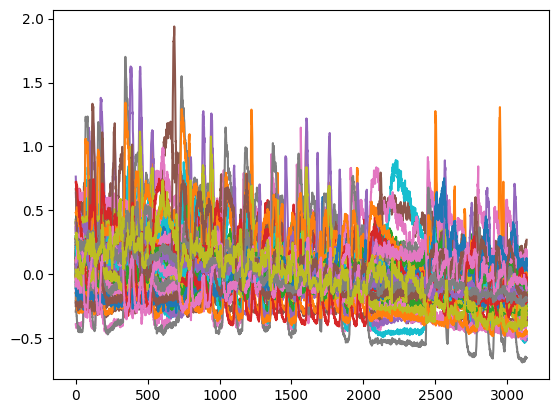

In [52]:
neurons = no_stim[0][0][0]
plt.plot(neurons)

print(no_stim[0][0][0].shape)